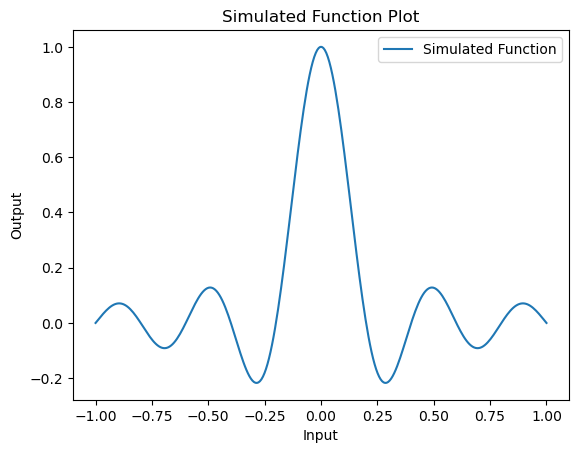

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.decomposition import PCA
torch.manual_seed(1)
x = torch.unsqueeze(torch.linspace(-1, 1, 300), dim=1)
y = (np.sin(5 * np.pi * x)) / (5 * np.pi * x)

# Use clone().detach() to avoid the warning
x = x.clone().detach().float()
y = y.clone().detach().float()

plt.plot(x, y, label='Simulated Function')
plt.title('Simulated Function Plot')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.show()


In [2]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # Define all layers in a list
        self.layers = nn.ModuleList([
            nn.Linear(1, 4),
            nn.Linear(4, 9),
            nn.Linear(9, 12),
            nn.Linear(12, 10),
            nn.Linear(10, 10),
            nn.Linear(10, 10),
            nn.Linear(10, 4)
        ])
        # The prediction layer
        self.predict = nn.Linear(4, 1)

    def forward(self, x):
        # Apply Leaky ReLU after each layer in the list
        for layer in self.layers:
            x = nn.functional.leaky_relu(layer(x))
        
        # Final prediction layer
        x = self.predict(x)
        return x     

In [3]:
model = Model()
# Using a list comprehension for better readability
params = [p.numel() for p in model.parameters()]
total_params = sum(params)
print(f'Total parameters: {total_params}')

Total parameters: 572


In [4]:
def train_model(model, x, y):
    epoch_size = 4000
    loss_arr = []
    epoch_arr = []
    grad_arr = []
    converged = False
    min_grad = 0
    lossm_val = 0
    minimal_ratio = 0.0

    for epoch in range(epoch_size):
        if converged:
            return epoch_arr, loss_arr, y_prediction, grad_arr

        # Forward pass
        y_prediction = model(x)
        loss = loss_func(y_prediction, y)

        # Zero gradients, backward pass, and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track epoch and loss
        epoch_arr.append(epoch)
        loss_arr.append(loss.detach().numpy())

        # Calculate gradient norm
        grad_norm = sum((p.grad.cpu().data.numpy()**2).sum() for p in model.parameters() if p.grad is not None) ** 0.5
        grad_arr.append(grad_norm)

        total_params = sum(p.numel() for p in model.parameters())

        # Check for convergence condition
        if grad_norm < 0.001 or epoch == epoch_size - 1:
            predicted_y = model(x)
            lossm = loss_func(predicted_y, y)

            # Construct the Hessian matrix
            H = torch.zeros((total_params, total_params))
            gradient = torch.autograd.grad(lossm, list(model.parameters()), create_graph=True)
            gradient = torch.cat([g.flatten() for g in gradient])

            for i in range(total_params):
                result = torch.autograd.grad(gradient[i], list(model.parameters()), retain_graph=True)
                H[i] = torch.cat([r.flatten() for r in result])

            # Eigenvalue computation for Hessian matrix
            H_eig = torch.linalg.eigvalsh(H, UPLO='U')
            positive_count = sum(1 for eig in H_eig.tolist() if eig > 0)
            minimal_ratio = positive_count / total_params

            print(f'Minimum value: {minimal_ratio}, Loss: {lossm.item()}, Current epoch: {epoch}')


            lossm_val = lossm.item()
            break

    return lossm_val, minimal_ratio


In [5]:
loss_arr, min_ratio_arr = [], []

for idx in range(100):
    print(f"Training model {idx}")  # idx gives us the model number

    # Initialize model, loss function, and optimizer
    model = Model()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    loss_func = torch.nn.MSELoss()

    # Train the model and capture the loss and minimal ratio
    loss_value, min_ratio = train_model(model, x, y)

    # Append the results to their respective arrays
    loss_arr.append(loss_value)
    min_ratio_arr.append(min_ratio)

     


Training model 0
Minimum value: 0.5384615384615384, Loss: 0.0004176404618192464, Current epoch: 904
Training model 1
Minimum value: 0.5384615384615384, Loss: 0.0026393532752990723, Current epoch: 1081
Training model 2
Minimum value: 0.5017482517482518, Loss: 0.08690247684717178, Current epoch: 24
Training model 3
Minimum value: 0.5244755244755245, Loss: 0.002725717145949602, Current epoch: 1117
Training model 4
Minimum value: 0.5017482517482518, Loss: 0.08689960837364197, Current epoch: 151
Training model 5
Minimum value: 0.5034965034965035, Loss: 0.08686992526054382, Current epoch: 98
Training model 6
Minimum value: 0.5437062937062938, Loss: 0.002382833743467927, Current epoch: 598
Training model 7
Minimum value: 0.5437062937062938, Loss: 0.0006523473421111703, Current epoch: 2507
Training model 8
Minimum value: 0.5262237762237763, Loss: 0.0026257268618792295, Current epoch: 532
Training model 9
Minimum value: 0.5017482517482518, Loss: 0.08690677583217621, Current epoch: 99
Training m

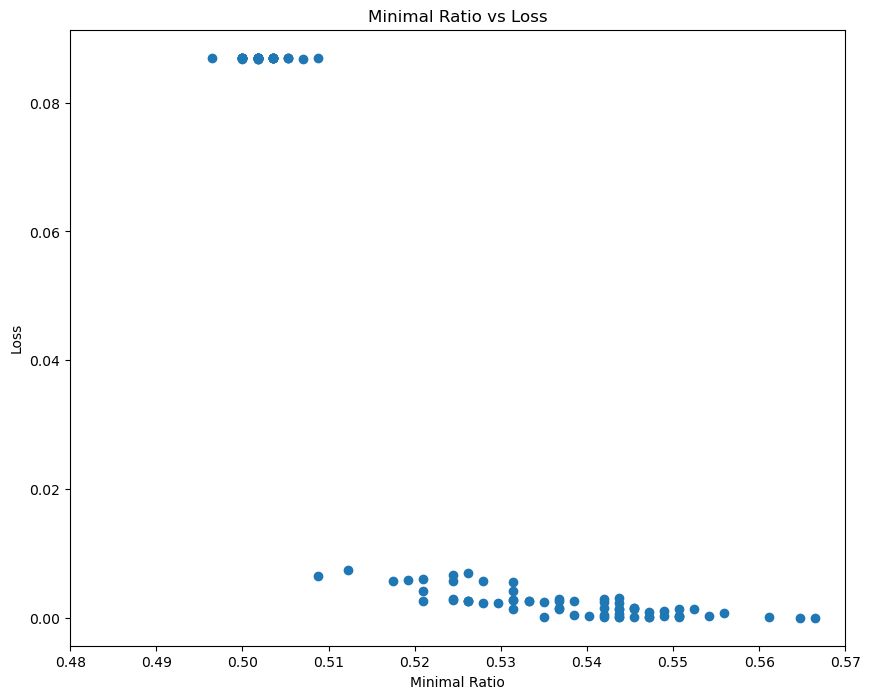

In [7]:
# Create a new figure with custom size
fig, ax = plt.subplots(figsize=(10, 8))

# Plot scatter plot of minimal ratio vs. loss
ax.scatter(min_ratio_arr, loss_arr)

# Set labels and title
ax.set_xlabel("Minimal Ratio")
ax.set_ylabel("Loss")
ax.set_title("Minimal Ratio vs Loss")

# Customize x-axis and y-axis limits
ax.set_xlim(0.48, 0.57)  # Set custom x-axis limits
# You can add a similar line for y-axis if needed: ax.set_ylim(y_min, y_max)
# Display the plot
plt.show()
